# Artificial Neural Networks

In this workshop we are going to implement a simple feed-forward artificial neural network (ANN) from scratch. The aim of this exercise is to give you a deeper understanding of how ANNs work "under the hood". Moreover, in this workshop, we are going to train an ANN for a classification task. Note that we do not have to come up with a particularly efficient ANN implementation (i.e., the one that works fast on large datasets). Rather our priority is to *develop code that works*, and is *easy to understand*. Also this exercise is not all about coding, but includes doing some simple maths too. 

In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

/home/nmathur/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


## The Dataset

We start with generating the data for binary classification. We are going to re-use a slightly modified dataset generation funciton from last week. The difference is that now the two classes are encoded as $0$ and $1$. In addition, we are not going to use collections any more.

In [3]:
def generate_s_shaped_data(gap=3):
    X = np.random.randn(80, 2)

    X[10:20] += np.array([3, 4])
    X[20:30] += np.array([0, 8])
    X[30:40] += np.array([3, 12])

    X[40:50] += np.array([gap, 0])
    X[50:60] += np.array([3 + gap, 4])
    X[60:70] += np.array([gap, 8])
    X[70:80] += np.array([3 + gap, 12])

    y = np.hstack([np.zeros(40), np.ones(40)])

    return X, y

We will use this function to generate data that is in general separable, but requires a non-linear separation boundary.

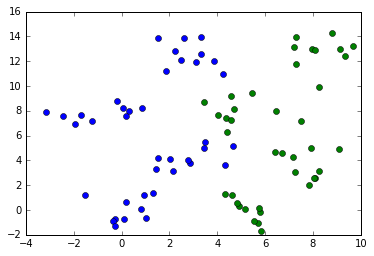

In [4]:
X,y = generate_s_shaped_data(5)
plt.plot(X[y==0,0], X[y==0,1], "o")
plt.plot(X[y==1,0], X[y==1,1], "o")

## The Model

Next, we define a particular ANN configuration that we are going to implement (see the figure below). We are working with two-dimensional input, hence two input units. Furthermore, we are going to do binary classification, for which one output unit would be sufficient. However, just to try backpropagation with multidimensional output, we are going to use two output units and their values will be indicative of conditional probabilities of each class $P(y=class_i|\bf{x},\bf{v},\bf{w})$. Finally, the number of hidden units $p$ will be provided by the user.

![](http://www.andreykan.com/stuff/workshop5-ann.png)

The equations define how the model is computed. Here $\sigma$ denotes logistic function. The derivatives are not used during model computation (forward computation), but we are going to need the soon during training. We are going to implement this ANN. Note that you can use *tanh* funciton from numpy, but we need to implement the logistic function.

In [ ]:
def logistic(s):
    # ... your code here ...
    
print(logistic(-100)) # ~0
print(logistic(0)) # 0.5 
print(logistic(100)) # ~1


Define some sample inputs to test our functions


In [5]:

x0 =np.asfarray([0,1])
y0 = np.asfarray([0,1])
V0 = np.asfarray([[1, 1],
       [-1, 0],
       [0, 1]])
W0 = np.asfarray([[1, 1],
       [1, -1],
       [0, 1]])

First, let's implement the forward computation for a single instance given some parameter values. Note that this function returns the output layer values.

In [ ]:
# x is a 2 element input representing a single training instance;
#
# V is a matrix with 3 rows and p columns, where the three rows
#     correspond to the bias and weights for the two inputs,
#     and columns correspond to hidden units;
#
# W is a matrix with (p+1) rows and 2 columns, where the rows
#     correspond to the bias and p hidden units, and columns
#     correspond to output elements;
#
# returns: a two element output layer, and a vector of hidden
#          node values with (p+1) elements, where the first
#          element is constant 1
#
def compute_forward(x,V,W):

    # append input, so that the bias can be handled naturally
    x_ext = np.append(1, x)

    # get the number of hidden units
    p = V.shape[1]
    u = np.zeros((p))

    # iterate over hidden units
    for i in range(p):
        
        u[i] = # ... your code here ...

    # append hidden layer, so that the bias can be handled naturally
    u_ext = np.append(1, u)

    # set the outputs
    z = np.zeros((2))
    
    z[0] = # ... over to you ...
    z[1] = # ... over to you ...

    return z, u_ext


print(compute_forward(x0,V0,W0))
# (array([ 0.8534092 ,  0.76895739]), array([ 1.        ,  0.76159416,  0.96402758]))


Next, let's implement a function that makes predictions based on the output layer values. This function is going to make predictions for the entire dataset. After implementing these two functions, you might like to play with toy data and manually picked parameter values just to validate the implementation.

In [ ]:
# X is a matrix with N rows and 2 columns, where
#     rows represent training instances
#
# V and W have the same interpretation as in compute_forward()
#
# returns: an N element vector with predictions (0 or 1 each)
#
def ann_predict(X,V,W):
    num_examples = X.shape[0]
    y_pred = np.zeros(num_examples)

    for i in range(num_examples):
        y_pred[i] = # ... over to you

    return y_pred


print(ann_predict(X, V0, W0))
# [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
#   1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.
#   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
#   1.  1.  1.  1.  1.  1.  1.  1.]

## Training the ANN

### Loss Function

Now that we have a model, we need to develop a training algorithm. Recall that the idea is to define a loss function and then find parameter values that minimise the loss.

Each training example comes with a true label which is either $0$ or $1$. For convenicence, we are going to encode the label as a two-component vector $\bf{y}$, such that only one of the components is one and another one is zero. Moreover, we will make a simplifying assumption that the two components are independent to get $$P\left(\bf{y}|\bf{x},\bf{V},\bf{W}\right)=\prod\limits_{k=1,2}z_k\left(\bf{x},\bf{V},\bf{W}\right)^{y_k}\left(1 - z_k\left(\bf{x},\bf{V},\bf{W}\right)\right)^{1-y_k}$$

This is clearly a wrong assumption, but it is going to be good enough for us to get an ANN working. This assumption can be dropped by using an additional special layer called *soft-max layer*, but this is beyond the scope of this tutorial.

Taking the algorithm of this probability and inverting the sign, so that maximising probability leads to minimising the loss, gives us cross-entropy loss (for a single training example) $$l\left(\bf{V},\bf{W}\right)=-\sum\limits_{k=1,2}y_kln(z_k)+(1-y_k)ln\left(1 - z_k\right)$$

Implement a function that computes the loss for a single training example and true label encoded as vector $\bf{y}$.

In [ ]:
# x, V and W have the same interpretation as in compute_forward()
#
# y is a two element encoding of a binary label, either t[0] = 1
#     and t[1] = 0, or the other way around
#
# returns: loss for a given training example and parameters
#
def compute_loss(x,y,V,W):
    # ... your code here ...
    return l


print(compute_loss(x0,[0,1],V0,W0))  #5.83805695223

### Backpropagation

We are going to use stochastic gradient descent, and in each iteration of this algorithm we need to compute parameter updates. The updates are based on partial derivatives $\frac{\partial l}{\partial v_{ij}}$ and $\frac{\partial l}{\partial w_{jk}}$. We are going to compute these derivatives using auxiliary quantities $\delta_k$ and $\varepsilon_{jk}$. Note that the multidimensional output, $\varepsilon_{jk}$, has two indices. Also note that the equations below assume that $x$ is a three-dimensional vector, after appending with a constant one to capture the bias, and, similarly, that $u$ is a $(p+1)$-dimensional vector with the first element constant one.

Let $l_k=-y_kln(z_k)-(1-y_k)ln\left(1 - z_k\right)$. The auxiliary quantities are $\delta_k=\frac{\partial l}{\partial s_k}$ and $\varepsilon_{jk}=\frac{\partial l_k}{\partial r_j}$. Use the identities provided in the ANN figure above to verify that

$\delta_k=\frac{\partial l_k}{\partial z_k}\frac{\partial z_k}{\partial s_k}=(z_k-y_k)$

$\frac{\partial l}{\partial w_{jk}}=\delta_ku_{j}$

$\varepsilon_{jk}=\frac{\partial l_k}{\partial z_k}\frac{\partial z_k}{\partial s_k}\frac{\partial s_k}{\partial u_j}\frac{\partial u_j}{\partial r_j}=\delta_k(1-u^2_j)w_{jk}$

$\frac{\partial l}{\partial v_{ij}}=\frac{\partial l_1}{\partial v_{ij}}+\frac{\partial l_2}{\partial v_{ij}}=\varepsilon_{j1}x_i+\varepsilon_{j2}x_i$

Now use these equations to implement a single update step.

In [ ]:
# x, V and W have the same interpretation as in compute_forward()
#
# y has the same interpretation as in compute_loss()
#
# returns: updated estimates of V and W
#
def update_params(x,y,V,W,eta):
    ### forward computation
    z, u_ext = compute_forward(x,V,W)

    # ... over to you
    ## use backpropagation equations to compute dV and dW

    V += -eta*dV
    W += -eta*dW

    return V,W

print(update_params(x0,y0, V0,W0, 1.))
# (array([[ 0.54455806,  1.01632335],
#        [-1.        ,  0.        ],
#        [-0.45544194,  1.01632335]]), array([[ 0.1465908 ,  1.23104261],
#        [ 0.35004854, -0.8240393 ],
#        [-0.82271001,  1.22273145]]))

And finally use the single update step in a function that performs training.

In [ ]:
# X is a matrix with N rows and 2 columns, where
#     rows represent training instances
#
# V0 and W0 are starting parameter values
# as before, V0 is a matrix with 3 rows and p columns, where
#     the three rows correspond to the bias and weights for
#     the two inputs, and columns correspond to hidden units;
#
# W0 is a matrix with (p+1) rows and 2 columns, where the rows
#     correspond to the bias and p hidden units, and columns
#     correspond to output elements;
#
# y is an N element array of true labels
#
# returns: trained values for V and W, as well as total loss
#          after each training epoch
#
def ann_train(X,y,V0,W0):
    # use starting values
    V = V0
    W = W0

    # step scale; note that this is usually changed (decreased)
    # between iterations, but we won't bother here
    eta = 0.01

    # number of rounds over the data
    num_epochs = 50

    # number of training examples
    num_examples = X.shape[0]

    # calculate total loss in each epoch
    l_total = np.zeros(num_epochs)

    # make several rounds over the data
    for j in range(num_epochs):
        # iterate trough each training example
        l_total[j] = 0
        for i in range(num_examples):
            curr_x = X[i,:]
            curr_y = np.zeros(2)
            curr_y[0] = (y[i] == 0)
            curr_y[1] = 1 - curr_y[0]
            V,W = update_params(curr_x,curr_y,V,W,eta)
            l_total[j] += compute_loss(curr_x,curr_y,V,W)

    return V,W,l_total

Let's try everything in action! We will start from some randomly generated parameters, perform training and compare the accuracy before and after the training. *Why not start with all parameters equal to zero?*

In [ ]:
# number of hidden units
p = 5

# initialisation
V0 = np.random.randn(3, p)
W0 = np.random.randn(p + 1, 2)

y_pred = ann_predict(X,V0,W0)
print('Proportion misclassified:')
prop = 1 - np.sum(y_pred == y) / float(y.shape[0])
if prop > 0.5:
    prop = 1 - prop
print(prop)


V,W,l_total = ann_train(X,y,V0,W0)

plt.figure()
plt.plot(range(l_total.shape[0]), l_total, '.-')

y_pred = ann_predict(X,V,W)
print('Proportion misclassified:')
prop = 1 - np.sum(y_pred == y) / float(y.shape[0])
if prop > 0.5:
    prop = 1 - prop
print(prop)

Note that our training procedure is not regularised. A natural next step would be to introduce regularisation weighted by $\lambda$, and estimate training meta-parameters, such as $p$, $\eta$, *number of epochs* and $\lambda$ using heldout validation. Another direction for future work is extending this ANN for multi-label classifictation.